In [62]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [167]:
df_all = pd.read_csv('fanfic_regression_data_curated.tsv', sep = '\t')

In [168]:
len(df_all)

576408

In [169]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [171]:
df_all.head(2)

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Relationship,Term_novelty,Topic_novelty,tag_novelty,...,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_homestuck,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,0.666667,1.0,3,0,106.666667,2.666667,No relationship,0.778655,0.599456,-0.012112,...,0,0,0,0,0,0,0,0,0,5120.0
1,0.000000,0.0,1,1,1359.000000,19.000000,Harry Potter/Severus Snape,0.879855,0.625602,NaN,...,0,0,0,0,0,0,0,0,0,5579.0


### Logistic

In [172]:
df_all['Intercept'] = 1.0

In [189]:
df_all['bms_binary'] = df_all['Bookmarks'].apply(lambda x: 1 if x != 0.0 else 0)

In [190]:
df_all['bms_binary'].value_counts()

1    441454
0     85538
Name: bms_binary, dtype: int64

In [191]:
df_all = df_all.replace([np.inf, -np.inf], np.nan)
df_all = df_all.dropna(how = 'any')

In [192]:
len(df_all)

526992

In [193]:
logit_model = sm.Logit(df_all["bms_binary"], df_all[['ChapterIndex', 'Chapters',\
        'Term_novelty', 'Topic_novelty','tag_novelty', \
        'Freq_relationship', 'Category_F_M',\
       'Category_Gen', 'Category_M_M', 'Category_Multi', 'Category_Other','Category_Unknown', \
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',\
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',\
       'ArchiveWarnings_blood', 'ArchiveWarnings_violence',\
       'ArchiveWarnings_noncon', 'Freq_author', 'Rating_G',\
       'Rating_M', 'Rating_N', 'Rating_T',\
       'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
       'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
       'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
       'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
       'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
       'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 'Fandom_homestuck', 'Fandom_marvel',
       'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
       'History', 'Intercept']]).fit(method='bfgs')

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  .. math:: \\ln\\lambda_{i}=x_{i}\\beta
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return kwds
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  .. math:: \\ln\\lambda_{i}=x_{i}\\beta
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return kwds


         Current function value: 0.382203
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 39


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  Hinv = np.linalg.inv(-retvals['Hessian']) / nobs
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  if 'use_t' in kwargs:


In [195]:
# logit_model.summary()

In [196]:
pred = logit_model.predict()

In [197]:
sorted(pred)

[0.1776231924402456,
 0.18350393903809556,
 0.18563428009762736,
 0.18742266879039024,
 0.19213297488048223,
 0.20369995928853235,
 0.20570273366706876,
 0.20775033043721805,
 0.2112650702989144,
 0.21153676857395715,
 0.21260818652601493,
 0.21263153470800875,
 0.21592799869535223,
 0.21704399045897607,
 0.2209645341899015,
 0.2218821678552085,
 0.22625494052704567,
 0.22776868478324688,
 0.23001296151575926,
 0.2302210830858725,
 0.2304737627513119,
 0.23333889540178399,
 0.23376579372224268,
 0.23632211373788345,
 0.23681523863019147,
 0.23709637064610228,
 0.23797335899769195,
 0.23832297983483933,
 0.23860869006533336,
 0.24015072112657795,
 0.24044703629520633,
 0.24080569259409315,
 0.24160236842117655,
 0.24299634701405096,
 0.24331344423395973,
 0.2447406722554686,
 0.2449476762589656,
 0.24643926137457986,
 0.2471125415965674,
 0.2486060906867146,
 0.24918832882936948,
 0.24944130432697142,
 0.24957388173450867,
 0.25008507061537366,
 0.2506154497337917,
 0.25083444815112976,

In [198]:
df_all['bms_nonzero_prob'] = pred

### OLS

In [199]:
df_all_log = df_all.copy()
df_all_log['Kudos'] = np.log(df_all_log['Kudos']+0.001)
df_all_log['Hits'] = np.log(df_all_log['Hits']+0.001)
df_all_log['Comments'] = np.log(df_all_log['Comments']+1)
df_all_log['Bookmarks'] = np.log(df_all_log['Bookmarks']+0.001)
df_all_log = df_all_log.replace([np.inf, -np.inf], np.nan)
df_all_log = df_all_log.dropna(how = 'any')

In [159]:
s = ''
for item in df_all.columns.values:
    s += item + ' + '

In [160]:
s

'Bookmarks + ChapterIndex + Chapters + Comments + Hits + Kudos + Relationship + Term_novelty + Topic_novelty + tag_novelty + Freq_relationship + Category_F_F + Category_F_M + Category_Gen + Category_M_M + Category_Multi + Category_Other + Category_Unknown + ArchiveWarnings_none + ArchiveWarnings_underage + ArchiveWarnings_death + ArchiveWarnings_choose_no + ArchiveWarnings_no_apply + ArchiveWarnings_blood + ArchiveWarnings_violence + ArchiveWarnings_noncon + Freq_author + Rating_E + Rating_G + Rating_M + Rating_N + Rating_T + Fandom_harry_potter + Fandom_dcu + Fandom_doctor_who + Fandom_star_wars + Fandom_arthurian + Fandom_supernatural + Fandom_haikyuu + Fandom_kuroko_no_basuke + Fandom_hamilton_miranda + Fandom_dragon_age + Fandom_the_walking_dead + Fandom_buffy + Fandom_les_miserables + Fandom_naruto + Fandom_tolkien + Fandom_shakespare + Fandom_hetalia + Fandom_attack_on_titan + Fandom_ms_paint_adventures + Fandom_homestuck + Fandom_marvel + Fandom_sailor_moon + Fandom_one_directio

In [204]:
model = ols("Bookmarks ~ Term_novelty + Topic_novelty \
 + ChapterIndex + Chapters + Freq_relationship  + Category_F_M + \
 Category_Gen + Category_M_M + Category_Multi + Category_Other + Category_Unknown \
 + ArchiveWarnings_underage + ArchiveWarnings_death + ArchiveWarnings_choose_no +\
 ArchiveWarnings_no_apply + ArchiveWarnings_blood + ArchiveWarnings_violence +\
 ArchiveWarnings_noncon + Freq_author  + Rating_G + Rating_M + Rating_N + Rating_T\
 + Fandom_dcu + Fandom_doctor_who + Fandom_star_wars + Fandom_arthurian + \
 Fandom_supernatural + Fandom_haikyuu + Fandom_kuroko_no_basuke + Fandom_hamilton_miranda\
 + Fandom_dragon_age + Fandom_the_walking_dead + Fandom_buffy + Fandom_les_miserables \
 + Fandom_naruto + Fandom_tolkien + Fandom_shakespare + Fandom_hetalia + \
 Fandom_attack_on_titan + Fandom_ms_paint_adventures + Fandom_homestuck +\
 Fandom_marvel + Fandom_sailor_moon + Fandom_one_direction + Fandom_sherlock \
 + History + bms_nonzero_prob", data = df_all_log).fit()

In [205]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Bookmarks   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     1979.
Date:                Tue, 03 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:50:17   Log-Likelihood:            -1.2722e+06
No. Observations:              526992   AIC:                         2.545e+06
Df Residuals:                  526944   BIC:                         2.545e+06
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

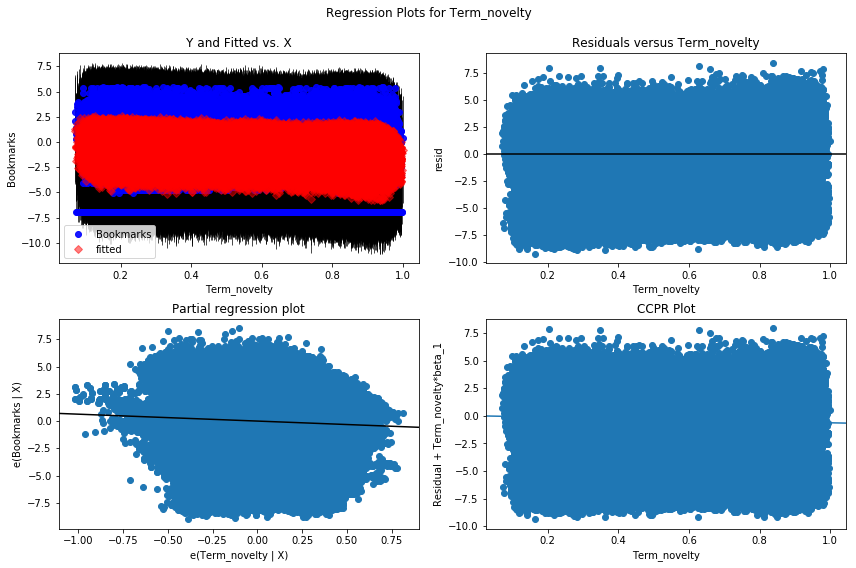

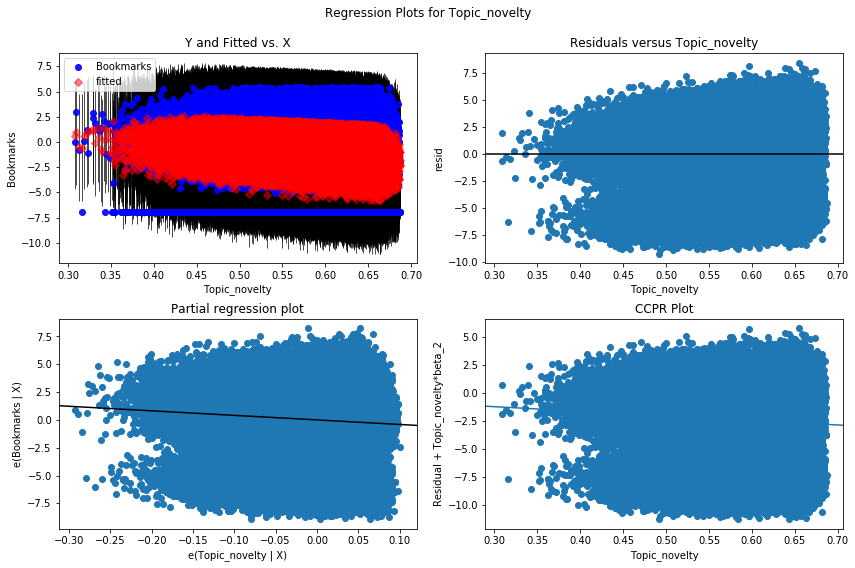

In [206]:
for item in ['Term_novelty', 'Topic_novelty']:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, item, fig=fig)
